In [2]:
%%time
%matplotlib inline
%run Prosser_header.py

dataset_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\datasets\\"
output_folder  = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\output\\"

Toggle code

Wall time: 8 ms


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, os
import pickle

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show,  output_notebook
from bokeh.layouts import column, row
from bokeh.embed import components
from bokeh.transform import factor_cmap
from bokeh.models import HoverTool
from bokeh.models import Span, Label
from bokeh.models import BoxAnnotation


output_notebook()

Loading BokehJS ...

In [4]:
def weighted_mean(x, **kws):
    val, weight = map(np.asarray, zip(*x))
    val, weight = val[~np.isnan(val)],weight[~np.isnan(val)]
    return (val * weight).sum() / weight.sum()

flatten = lambda l: [item for sublist in l for item in sublist]

In [24]:
x_axis = "Support Base Affluence"
y_axis = "Support For Redistribution"

In [26]:
partyfacts_core_parties_newest = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+"Newest version"+os.sep+"partyfacts-core-parties.csv")
partyfacts_external_parties_newest = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+"Newest version"+os.sep+ "partyfacts-external-parties.csv")
partyfacts_countries = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-countries.csv")
partyfacts_datasets = pd.read_csv(dataset_folder+"PartyFacts"+os.sep+ "partyfacts-datasets.csv")

# partyfacts_core_parties_newest[partyfacts_core_parties_newest["name_short"].isnull()]
## 

# 5307: Kokumin Kyōkai: no abbreviation - but "KK" seems to be free!
# 7619: National Alliance : "NA"
# 8081: National Union: "NU"??? (could be NA, but more distinct from National Alliance)
# 8454: Nauru First: No abbreviation ... because only party in Nauru I guess should be "NA" because name in Nauru?

partyfacts_core_parties_newest.loc[partyfacts_core_parties_newest["partyfacts_id"]==5307,"name_short"] = "KK"
partyfacts_core_parties_newest.loc[partyfacts_core_parties_newest["partyfacts_id"]==7619,"name_short"] = "NA"
partyfacts_core_parties_newest.loc[partyfacts_core_parties_newest["partyfacts_id"]==8081,"name_short"] = "NU"
partyfacts_core_parties_newest.loc[partyfacts_core_parties_newest["partyfacts_id"]==8454,"name_short"] = "NA"



abbreviation = partyfacts_core_parties_newest.set_index("partyfacts_id")["name_short"]

In [8]:
df_merged = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df_merged.zip",compression='zip')
df_merged = df_merged.reset_index().groupby("partyfacts_id").first()
manifesto_redist = df_merged[["(manifesto)per"+x for x in ["404","405","409","413","504","701"]]].sum(axis=1)

## some duplicates partyfacts_id here, but the manifesto data is identical in each case, so just just drop duplicates
manifesto_redist = manifesto_redist.reset_index().drop_duplicates().set_index("partyfacts_id")[0]
party_family = df_merged[search(df_merged,"\(manifesto\)family").index].idxmax(axis=1).apply(lambda x: x.replace("(manifesto)family__","") if pd.notnull(x) else np.nan)
party_family = party_family.reset_index().drop_duplicates().set_index("partyfacts_id")[0]

In [9]:
resp_df = pd.read_pickle(dataset_folder + "CSES"+os.sep+"Integration"+os.sep+"resp_df.pkl")

In [10]:
mask = resp_df["IMD2006_ORD"].notnull()\
        &resp_df["highest_freq_party_ref"].notnull()\
        &resp_df["highest_freq_party_ref"].apply(lambda x: x in list(party_family.index))

respondent_favoured_party = resp_df["highest_freq_party_ref"][mask]
respondent_income_quintile = resp_df["IMD2006_ORD"][mask]


In [11]:
respondent_inc_quin_by_party_family = pd.concat([respondent_favoured_party,respondent_income_quintile],axis=1)
respondent_inc_quin_by_party_family["highest_freq_party_ref"] = respondent_inc_quin_by_party_family["highest_freq_party_ref"].apply(lambda x:party_family.loc[x])

In [12]:
resp_inc_label="income quintile (1-5)"
resp_party_label = "party family"
respondent_inc_quin_by_party_family = respondent_inc_quin_by_party_family\
                                .rename(columns ={"highest_freq_party_ref":resp_party_label,"IMD2006_ORD":resp_inc_label})
respondent_inc_quin_by_party_family["weights"] = resp_df["IMD1010_1_MET"][mask]
respondent_inc_quin_by_party_family[resp_inc_label] = respondent_inc_quin_by_party_family[resp_inc_label].astype(int)+1

In [ ]:
## raw count - no weighting!
# what's the laziest way to add semi-reasonable weights here?

# sns.countplot(data=respondent_inc_quin_by_party_family,hue=resp_inc_label,x=resp_party_label)
# plt.xticks(rotation=45);

In [13]:
ct = pd.crosstab(respondent_inc_quin_by_party_family[resp_inc_label],
            respondent_inc_quin_by_party_family[resp_party_label],
            aggfunc=sum,values=respondent_inc_quin_by_party_family["weights"],
            normalize='columns'
           )*100

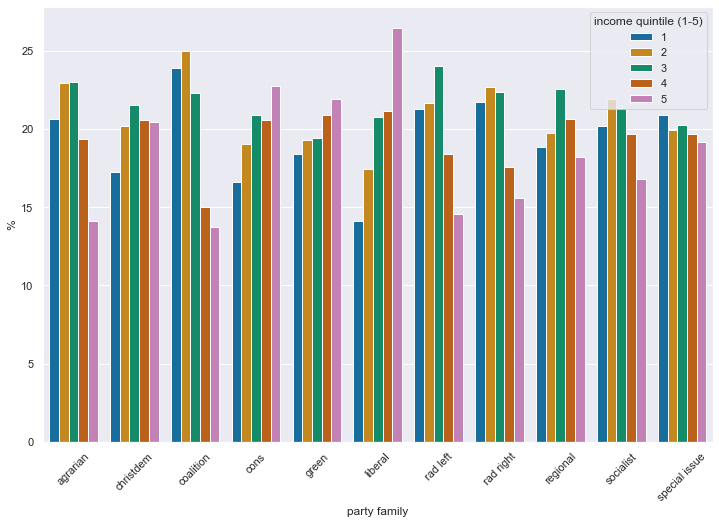

In [14]:
plt.figure(figsize = (12,8));
sns.barplot(data=ct.reset_index().melt(id_vars = resp_inc_label,value_name="%"),
            x = resp_party_label,
            hue = resp_inc_label,
            y="%");
plt.xticks(rotation=45);

In [ ]:
## Not sure what the takehome is here
# maybe means aren't the best summary for support base affluence
# maybe they are, but you still want to think about the broader distribution?

# very rough stuff - goodness knows what sort of weird effects you get from jamming parties together like this are

# also, always important to remember that income != wealth

In [15]:
resp_df_count_partyear = pd.read_pickle(dataset_folder + "CSES"+os.sep+"Integration"+os.sep+\
                                        "respond_sample_broad_count_ptryr.pkl").drop("index",axis=1)

In [16]:
resp_df_mean_partyear = pd.read_pickle(dataset_folder + "CSES"+os.sep+"Integration"+os.sep+\
                                        "respond_sample_broad_mean_ptryr.pkl").drop("index",axis=1)

In [17]:
resp_df_mean_partyear = resp_df_mean_partyear.set_index(["partyfacts_id","year"])

# messy extra index

In [18]:
party_level = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df.zip",compression='zip')
party_level = party_level.set_index(["partyfacts_id","year"])
party_year_overlap = list( set(resp_df_mean_partyear.index).intersection(party_level.index) )

In [19]:
manifesto_redist = party_level[["(manifesto)per"+x for x in ["404","405","409","413","504","701"]]].sum(axis=1)
manifesto_redist[party_level[["(manifesto)per"+x for x in ["404","405","409","413","504","701"]]].isnull().all(axis=1)]=np.nan

## some duplicates partyfacts_id here, but the manifesto data is identical in each case, so just just drop duplicates
manifesto_redist = manifesto_redist.reset_index().drop_duplicates().set_index(["partyfacts_id","year"])[0]
party_family = party_level["(manifesto)family"].dropna()
# party_level[search(party_level,"\(manifesto\)family").index].dropna().idxmax(axis=1).apply(lambda x: x.replace("(manifesto)family__","") if pd.notnull(x) else np.nan)
# party_family = party_family.reset_index().drop_duplicates().set_index("partyfacts_id")[0]

party_year_overlap = manifesto_redist.loc[party_year_overlap][manifesto_redist.loc[party_year_overlap].notnull()].index
# manifesto_redist.loc[party_year_overlap].isnull().sum()

In [20]:
# search(resp_df_mean_partyear,"IMD2006")

party_year_overlap = resp_df_mean_partyear.loc[party_year_overlap][resp_df_mean_partyear.loc[party_year_overlap,"IMD2006_ORD"].notnull()].index


In [21]:
parties_with_5_plus_refs = resp_df_mean_partyear.loc[ party_year_overlap ].reset_index()["partyfacts_id"].value_counts()[ resp_df_mean_partyear.loc[ party_year_overlap ].reset_index()["partyfacts_id"].value_counts()>=5 ].index

In [22]:
party_year_overlap_small = manifesto_redist.loc[ party_year_overlap ].dropna().loc[parties_with_5_plus_refs,:].index

In [27]:
income_by_party_redist_year_party = manifesto_redist.loc[ party_year_overlap_small ].dropna().reset_index().merge(resp_df_mean_partyear.loc[ party_year_overlap_small ,"IMD2006_ORD"].reset_index(),on=["partyfacts_id","year"],how='left')
income_by_party_redist_year_party = income_by_party_redist_year_party.rename(columns = {"IMD2006_ORD":x_axis,0:y_axis})
income_by_party_redist_year_party["partyfacts_id"] = income_by_party_redist_year_party["partyfacts_id"].astype(int)
income_by_party_redist_year_party["Abbreviation"] = income_by_party_redist_year_party["partyfacts_id"].apply(lambda x: abbreviation.loc[x])

In [28]:
party_family = party_family.reset_index().drop_duplicates().set_index(["partyfacts_id","year"])

In [29]:
income_by_party_redist_year_party["Party Family"] = party_family.loc[ income_by_party_redist_year_party.set_index(["partyfacts_id","year"]).index ].values
income_by_party_redist_year_party["Party Family"] = income_by_party_redist_year_party["Party Family"].astype('category')
income_by_party_redist_year_party["year"] = income_by_party_redist_year_party["year"].astype('category')

In [30]:
party_colour_dict = {k.split(" (")[0]:v for k,v in party_colour_dict.items()}

NameError: name 'party_colour_dict' is not defined

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = income_by_party_redist_year_party,x=x_axis,y=y_axis,
                hue="Party Family",palette=party_colour_dict);
# ,palette=party_colour_dict
# make size = percentage of the vote? "pervote"

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=8)

label_point(income_by_party_redist_year_party[x_axis],
            income_by_party_redist_year_party[y_axis],
            income_by_party_redist_year_party["Abbreviation"], plt.gca())

# plt.xlabel("Support Base Affluence");
# plt.ylabel("Support For Redistribution");
# plt.gca().legend(title='Party Family');

In [ ]:
income_by_party_redist_year_party["year"] = income_by_party_redist_year_party["year"].astype(str).astype('category')
income_by_party_redist_year_party["partyname"] = partyfacts_core_parties_newest.set_index("partyfacts_id")["name_english"].loc[income_by_party_redist_year_party["partyfacts_id"]].values
income_by_party_redist_year_party["partyname"] = income_by_party_redist_year_party["partyname"].astype('category')
spec_party_colour_dict = dict( zip( income_by_party_redist_year_party["country_abbrev"].cat.categories, cycle(list(party_colour_dict.values())) ) )

In [ ]:
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
# colours = mps["party"].replace(party_colour_dict).values
# colors = factor_cmap('year', palette=list(party_colour_dict.values()), factors=list(party_colour_dict.keys()))
colors = factor_cmap('year', palette=list(spec_party_colour_dict.values()), factors=list(spec_party_colour_dict.keys()))

hover = HoverTool(tooltips = [('name','@partyname'),
                              ('abbrev','@abbrev'),
                              ('year','@year'),
                              ('party family','@{Party Family}'),
#                             ('country','@country'),
#                               ('abbrev','@Abbreviation'),
                              ('N = ','@{sample size}'),
#                               ('right-left','@rile'),
#                               ('planned economy','@planeco'),
#                               ('market economy','@markeco'),
#                               ('welfare','@welfare'),
#                               ('intpeace','@intpeace')
                             ])

p1 = figure(plot_width=950, plot_height=800, title="Party Manifesto 'Redistributiveness' by Mean Electorate Income Decile",
            tools='box_select,pan,wheel_zoom,box_zoom,reset', active_drag="box_select",
            x_axis_label = "Support Base Affluence",y_axis_label="Support For Redistribution",)
for family in income_by_party_redist_year_party["country_abbrev"].cat.categories:
    if family[0:3]!="DEU":
        continue
    mask = income_by_party_redist_year_party["country_abbrev"]==family
    source = ColumnDataSource(income_by_party_redist_year_party[mask])
    p1.scatter('Support Base Affluence', 'Support For Redistribution',source=source,
                alpha=0.7,line_color = spec_party_colour_dict[family], fill_color=spec_party_colour_dict[family],
               legend_label=family)

    labels = LabelSet(x=x_axis, y=y_axis, text='year', level='glyph',
             x_offset=0, y_offset=0, source=source)

    p1.add_layout(labels)
# source = ColumnDataSource(income_by_party_redist_year_party)
# p1.scatter('Support Base Affluence', 'Support For Redistribution',source=source,
#             alpha=0.7
# #            ,line_color = year_colour_dict[family], fill_color=year_colour_dict[family],
# #            legend_label=family
#           )
#     #,size='pervote_smaller')
    #
#     
    
#     p1.scatter('weighted_income_deciles', 'manifesto_redist', source=source, fill_color=colors, line_color = colors, alpha=0.7,
#               legend_group='parfam',size='pervote_smaller',)

p1.add_tools(hover)
p1.legend.location = "top_left"
p1.legend.click_policy="hide"
show(p1)